# Convnet based Model

## Import packages

In [3]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json

from keras.models import Sequential,Model
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda
from keras.layers import Conv1D , Flatten, Input
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D



from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
from keras import backend as K








from sklearn.model_selection import train_test_split


Using TensorFlow backend.


## Initialize global variables

In [4]:


path = '/home/ubuntu/quora/'
data_home = path +"data/"

Q1_TRAINING_DATA_FILE = data_home+'cache/q1_train.npy'
Q2_TRAINING_DATA_FILE = data_home+'cache/q2_train.npy'
LABEL_TRAINING_DATA_FILE = data_home+'cache/label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = data_home+'cache/word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = data_home+'cache/nb_words.json'
Q1_TESTING_DATA_FILE = 'q1_test.npy'
Q2_TESTING_DATA_FILE = 'q2_test.npy'

# Q1_TRAINING_DATA_FILE = data_home+'cache/q1_train_google.npy'
# Q2_TRAINING_DATA_FILE = data_home+'cache/q2_train_google.npy'
# LABEL_TRAINING_DATA_FILE = data_home+'cache/label_train.npy'
# WORD_EMBEDDING_MATRIX_FILE = data_home+'cache/word_embedding_matrix_google.npy'
# NB_WORDS_DATA_FILE = data_home+'cache/nb_words_google.json'
# Q1_TESTING_DATA_FILE = 'q1_test_google.npy'
# Q2_TESTING_DATA_FILE = 'q2_test_google.npy'





MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25


re_weight = True # whether to re-weight classes to fit the 17.5% share in test set


## Load the dataset, embedding matrix and word count

In [5]:
# q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
# q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
# labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
# word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
# with open(NB_WORDS_DATA_FILE, 'r') as f:
#     nb_words = json.load(f)['nb_words']

In [4]:
q1_data.shape,q2_data.shape

((404290, 35), (404290, 35))

In [13]:
data_1 = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
data_2 = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']




test_data_1 = np.load(open(data_home+"cache/"+Q1_TESTING_DATA_FILE, 'rb'))
test_data_2 = np.load(open(data_home+"cache/"+Q2_TESTING_DATA_FILE, 'rb'))




In [14]:

perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))

In [15]:
weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344


## Partition the dataset into train and test sets

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=2019)


In [6]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
# Q1_train = X_train[:,0]
# Q2_train = X_train[:,1]
# Q1_test = X_test[:,0]
# Q2_test = X_test[:,1]

In [7]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



TRAIN: [337176  17039  75113 ...,  41001 336218 115328] TEST: [283851 377233  35357 ..., 392228 325350 150065]


In [8]:
# Q1_train = X_train[:,0]
# Q2_train = X_train[:,1]
# Q1_test = X_test[:,0]
# Q2_test = X_test[:,1]

In [9]:
#stacking Q1 and Q2
Q1_train = np.vstack((X_train[:,0],X_train[:,1]))
Q2_train = np.vstack((X_train[:,1],X_train[:,0]))
Q1_test = np.vstack((X_test[:,0],X_test[:,1]))
Q2_test = np.vstack((X_test[:,1],X_test[:,0]))


In [10]:
y_train = np.concatenate((y_train, y_train))
y_test = np.concatenate((y_test, y_test))

In [11]:
len(Q1_train),len(Q2_train),len(y_train),len(Q1_test),len(Q1_test),len(y_test)

(727722, 727722, 727722, 80858, 80858, 80858)

## Define the model

### Set weights 

In [9]:
re_weight = True 

if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None
    
    
weight_val = np.ones(len(y_test))
if re_weight:
    weight_val *= 0.472001959
    weight_val[y_test==0] = 1.309028344    

In [46]:
def get_convs():
#v2
    graph_in = Input(shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM))
#     normalized_input = BatchNormalization()(graph_in)
    
    convs = []

    for fsz in range(2,6): #conv > batch > max
        conv = Conv1D(80, fsz,
                      padding = 'valid', activation='relu')(graph_in)#
        conv = Dropout(0.3)(conv)
        conv = BatchNormalization()(conv)        
        
        pool = MaxPooling1D(pool_size=2)(conv)
#renaming pool to conv to avoid mistakes
#         conv = MaxPooling1D(pool_size=2)(conv)

#         # v3 second layer convs
#         conv = Conv1D(32, fsz,
#                       padding = 'valid', activation='relu')(conv)#
#         conv = BatchNormalization()(conv)        
        
#         pool = MaxPooling1D(pool_size=2)(conv)

          
        flatten = Flatten()(pool)
#         pool = GlobalMaxPooling1D()(conv)
        convs.append(flatten)

    out = Merge(mode='concat')(convs) 
    graph = Model(input=graph_in,output=out)

    return graph


# v1
#     graph_in = Input(shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM))
#     convs = []

#     for fsz in range(3,6):
#         conv = Conv1D(256, fsz,strides=1,
#                             padding = 'valid', activation='relu')(graph_in)#

#         pool = MaxPooling1D(pool_length=2)(conv)
#         flatten = Flatten()(pool)
#         convs.append(flatten)

#     out = Merge(mode='concat')(convs) 
#     graph = Model(input=graph_in,output=out)


In [47]:




### add computation graph to question 1 embeddings
graph = get_convs()

Q1 = Sequential()
Q1.add(Embedding(nb_words+1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))


Q1.add(graph)



### Same ops for question 2

Q2 = Sequential()
Q2.add(Embedding(nb_words+1,
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))


Q2.add(graph)


model = Sequential()
model.add(Merge([Q1, Q2], mode='concat'))
# concat = Concatenate([Q1, Q2])
# model.add(concat)
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(150, activation='relu'))
# model.add(Dropout(0.2))

# model.add(BatchNormalization())
# model.add(Dense(200, activation='relu'))

model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy'])#, 'precision', 'recall', 'fbeta_score'])

/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/ipykernel/__main__.py:30: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/ipykernel/__main__.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("me..., inputs=Tensor("in...)`
/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/ipykernel/__main__.py:34: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [48]:
# graph.summary()

## Train the model, checkpointing weights with best validation accuracy

In [49]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()

MODEL_WEIGHTS_FILE = path+'weights/1d_conv_v2_kernel128x2_5_prepC_glove_randomshuffle_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5'

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_loss', save_best_only=True),early_stopping]

history = model.fit([data_1_train, data_2_train],
                    labels_train,
                    epochs=50,
                    batch_size=2048,
#                     validation_split=VALIDATION_SPLIT,
                    validation_data = ([data_1_val, data_2_val],labels_val,weight_val),
                    callbacks=callbacks,
                    shuffle=True,
                    class_weight=class_weight)


t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-05-04 16:22:25.704432
Train on 727722 samples, validate on 80858 samples
Epoch 1/50
727722/727722 [==============================] - 164s - loss: 0.3954 - acc: 0.7139 - val_loss: 0.3458 - val_acc: 0.6938
Epoch 2/50
727722/727722 [==============================] - 156s - loss: 0.3192 - acc: 0.7524 - val_loss: 0.3157 - val_acc: 0.7405
Epoch 3/50
727722/727722 [==============================] - 156s - loss: 0.2941 - acc: 0.7745 - val_loss: 0.2960 - val_acc: 0.7707
Epoch 4/50
727722/727722 [==============================] - 156s - loss: 0.2762 - acc: 0.7907 - val_loss: 0.2905 - val_acc: 0.7755
Epoch 5/50
727722/727722 [==============================] - 156s - loss: 0.2619 - acc: 0.8030 - val_loss: 0.2838 - val_acc: 0.7871
Epoch 6/50
727722/727722 [==============================] - 155s - loss: 0.2503 - acc: 0.8141 - val_loss: 0.2778 - val_acc: 0.7947
Epoch 7/50
727722/727722 [==============================] - 155s - loss: 0.2399 - acc: 0.8234 - val_loss: 0.2782 - 

## Plot training and validation accuracy

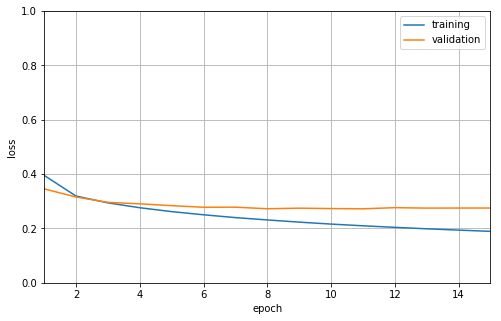

In [50]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("loss")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

without cleaning: Maximum accuracy at epoch 8 = 0.8227
with cleaning: Maximum accuracy at epoch 15 = 0.8268
with cleaning and stratified: 0.8275

In [51]:
max_val_acc, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum Loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Minimum Loss at epoch 11 = 0.2723


# LOAD the best weights

In [15]:
# !ls weights/

In [52]:
model.load_weights(path+"weights/1d_conv_v2_kernel128x2_5_prepC_glove_randomshuffle_epoch_10_val_loss_0.27.h5")


## Evaluate the model with best validation accuracy on the test partition

In [35]:
# loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test) #, precision, recall, fbeta_score
# print('')
# print('loss      = {0:.4f}'.format(loss))
# print('accuracy  = {0:.4f}'.format(accuracy))
# # print('precision = {0:.4f}'.format(precision))
# print('recall    = {0:.4f}'.format(recall))
# print('F         = {0:.4f}'.format(fbeta_score))

In [54]:
val_preds = model.predict([data_1_val, data_2_val])



NameError: name 'y_test' is not defined

In [55]:
from sklearn.metrics import log_loss


print (log_loss(labels_val,val_preds))
print (log_loss(labels_val,np.clip(val_preds,1-0.90,0.90)))
print (log_loss(labels_val,np.clip(val_preds,1-0.98,0.98)))
print (log_loss(labels_val,np.clip(val_preds,1-0.99,0.99)))


0.44603705516
0.43719993048
0.435078331711
0.437864553618


## Making predictions on test set

In [56]:
q1_test_data = np.load(open(data_home+"cache/"+Q1_TESTING_DATA_FILE, 'rb'))
q2_test_data = np.load(open(data_home+"cache/"+Q2_TESTING_DATA_FILE, 'rb'))

In [57]:
%%time

preds = model.predict([q1_test_data,q2_test_data], batch_size=4096)
preds_reverse = model.predict([q2_test_data,q1_test_data], batch_size=4096)

CPU times: user 49.7 s, sys: 9.61 s, total: 59.3 s
Wall time: 5min 51s


In [58]:
preds = (preds + preds_reverse)/2.0

In [59]:
preds.shape

(2345796, 1)

In [61]:
clip =0.98

# flattend = preds.flatten()

clipped = preds.ravel()#np.clip(flattend,1-clip,clip)

In [62]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': clipped})
sub.head(2)

,is_duplicate,test_id
0,0.000960,0
1,0.072982,1


In [63]:
submission_name = "subm/1d_conv_v2_kernel128x2_5_prepC_glove_randomshuffle_noclip.csv"

sub.to_csv(path+submission_name, index=False)

In [64]:
from IPython.lib.display import FileLink

FileLink(submission_name)

/home/ubuntu/quora/subm/1d_conv_v2_kernel128x2_5_prepC_glove_randomshuffle_noclip.csv